# Fig. 7: Model evaluation

In [1]:
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes as shapes

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('seaborn-colorblind')

2019-05-08 11:16:40,046 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
# Because the particle swarm gives different results depending on the initial
# conditions, we ran each CV fold multiple times (random init). Here we need
# to comb through these simulation runs and find the one that gave the best
# score (for each fold):
results_dir = '../results'
col_score = 'best_train_score'
col_groupby = ['subject', 'modelname', 'idx_fold']

try:
    # For all files of a given subject, model, CV fold (`col_groupby`), find the
    # best `col_score`:
    files = shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)
except FileNotFoundError:
    # Results directory does not exist (or no files found). In this case, download
    # the data from OSF:
    shapes.fetch_data(osf_zip_url='https://osf.io/prv5z', save_path=results_dir)
    files = shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)

In [3]:
y_true = []
y_pred = []
for file in files:
    yt, yp, _, specifics = pickle.load(open(file, 'rb'))
    yt = yt[0].drop(columns=['image'])
    yp = yp[0].drop(columns=['image'])
    for col in ['x_center', 'y_center']:
        if col in yt.columns:
            yt.drop(columns=col, inplace=True)
        if col in yp.columns:
            yp.drop(columns=col, inplace=True)
    for g in col_groupby:
        yt[g] = specifics[g]
    yt['orientation'] = np.rad2deg(yt['orientation'])
    yp['orientation'] = np.rad2deg(yp['orientation'])
    y_true.append(yt)
    y_pred.append(yp)

# Put everything in a single data frame (columns from `y_pred` will have a '_p'
# suffix):
ytyp = pd.concat((pd.concat(y_true),
                  pd.concat(y_pred).add_suffix('_p')),
                 axis=1)

In [4]:
subjects = ytyp.subject.unique().tolist()
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 6], [0, 2400], [-90, 90], [0, 1]]

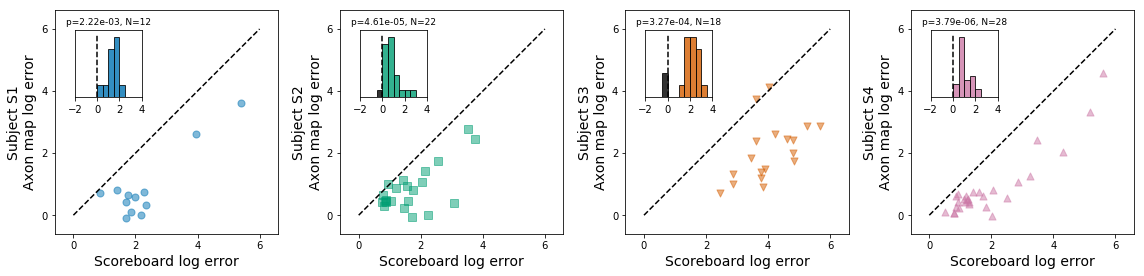

In [5]:
shape_loss = shapes.models.ShapeLossMixin()

fs = 14  # font size
hist_range = (-2, 4)  # log error range for histogram insets
ticks = [0, 6]  # plot ticks

fig, axes = plt.subplots(ncols=len(subjects), figsize=(16, 4))
for (subject, data), marker, color, ax in zip(ytyp.groupby('subject'), markers, colors, axes):
    n_folds = len(data.idx_fold.unique())
    xvals = []
    yvals = []
    # Calculate shape loss for each drawing, fold by fold:
    for (_, rows) in data.groupby('idx_fold'):
        rows_a = rows[rows.modelname == 'Scoreboard']
        rows_c = rows[rows.modelname == 'AxonMap']
        # y_true and y_pred are in the same DataFrame, but predicted shape descriptors
        # have suffix '_p', e.g. 'area_p':
        xvals.append(shape_loss.calc_shape_loss(rows_a, rows_a, suffix='_p') / len(rows_a))
        yvals.append(shape_loss.calc_shape_loss(rows_c, rows_c, suffix='_p') / len(rows_c))
    xvals = np.log10(np.nan_to_num(xvals))
    yvals = np.log10(np.nan_to_num(yvals))
    ax.scatter(xvals, yvals, marker=marker, s=50, c=color, alpha=0.5)
    ax.set_xlabel('Scoreboard log error', fontsize=fs)
    ax.set_ylabel('Subject %s\nAxon map log error' % subject, fontsize=fs)
    ax.set_xticks(np.linspace(*ticks, num=4))
    ax.set_yticks(np.linspace(*ticks, num=4))
    ax.plot([ticks[0], ticks[1]], [ticks[0], ticks[1]], 'k--')
    ax.axis('square')
    lim = [1.1 * ticks[0] - 0.1 * ticks[1], 1.1 * ticks[1] - 0.1 * ticks[0]]
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)

    # Show histogram of errors as insets:
    axins = inset_axes(ax, width="30%", height="30%", loc=2, borderpad=2)
    n, bins, patches = axins.hist(xvals - yvals,
                                  bins=12, range=hist_range, 
                                  color=color, alpha=0.8)
    [patches[i].set_facecolor('k') for i in range(4)]
    [p.set_edgecolor('k') for p in patches]
    a = axins.axis()
    axins.plot([0, 0], [0, a[3]], 'k--')
    axins.set_yticks([])
    axins.set_xticks(np.int32(np.linspace(*hist_range, num=4)))
    axins.set_xlim(*hist_range)
    w = spst.wilcoxon(xvals, yvals)
    axins.set_title('p=%.2e, N=%d' % (w.pvalue, len(xvals)), fontsize=9)
fig.tight_layout()
fig.savefig('fig7-model-scatter.pdf', transparent=True)